In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", ".."))

# Into a graph

Explore putting the geometric data into a graph data structure.  We need to check that the input geometry reasonably respects the "graph/network nature" of the road system.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import geopandas as gpd
import os
import descartes
import numpy as np

import open_cp.network
import open_cp.plot
import matplotlib.collections

# UK Ordnance Survey data

In [3]:
ordnancedir = os.path.join("/media", "disk", "OS_OpenMap")
openroadsdir = os.path.join(ordnancedir, "oproad_essh_gz", "data")
file = "SE_RoadLink.shp"
se_frame = gpd.GeoDataFrame.from_file(os.path.join(openroadsdir, file))
se_frame.head()

,class,endNode,fictitious,formOfWay,function,geometry,identifier,length,loop,name1,name1_lang,name2,name2_lang,nameTOID,numberTOID,primary,roadNumber,startNode,structure,trunkRoad
0,Not Classified,0CFF70C2-9B29-472E-8A27-CCEA9997037B,false,Single Carriageway,Restricted Local Access Road,"LINESTRING Z (498830.04 441139.46 0, 499026.35...",EA197664-1E58-443D-9370-7C0CD5178DA1,394,false,None,None,None,None,None,None,false,None,A96F9634-8C61-4CF4-9AD0-C8EADA3D7A5B,None,false
1,Unclassified,7D94180C-9D5B-4793-BD55-8BEA91240B9C,false,Single Carriageway,Minor Road,"LINESTRING Z (498926.33 439826.29 0, 498919.15...",9C3EA9EC-5EBB-4487-BEC6-7AC72DA0C31A,57,false,Pudding Gate,None,None,None,osgb4000000010952647,None,false,None,6B9832C7-0778-4ECA-9EC5-C67C700FDFED,None,false
2,Unclassified,0EE39E69-E9D6-4D3A-92A3-E173B28B3C1B,false,Single Carriageway,Minor Road,"LINESTRING Z (498911.98 439771.47 0, 498917.32...",CA83540D-83BF-4204-BADE-DEC248606D64,17,false,Joby Lane,None,None,None,osgb4000000010968479,None,false,None,7D94180C-9D5B-4793-BD55-8BEA91240B9C,None,false
3,Unclassified,D00D9ABE-2FE6-41CA-A56C-C594B9777AEB,false,Single Carriageway,Minor Road,"LINESTRING Z (498922.66 439757.84 0, 498928.97...",E3E62810-76D5-42B0-89D5-69721D2F719B,72,false,Joby Lane,None,None,None,osgb4000000010968479,None,false,None,0EE39E69-E9D6-4D3A-92A3-E173B28B3C1B,None,false
4,Unclassified,6B9832C7-0778-4ECA-9EC5-C67C700FDFED,false,Single Carriageway,Local Road,"LINESTRING Z (498922.66 439757.84 0, 498944.29...",F2867AC1-AB45-4E54-825B-B1CF4FD90AED,123,false,None,None,None,None,None,None,false,None,0EE39E69-E9D6-4D3A-92A3-E173B28B3C1B,None,false


We notice that each edge has a UUID-like identifier for the start and end node.

- Does the said ID always correspond to _exactly_ the same coordinate?  YES!
- Does _exactly_ the same coordinate always correspond to the same ID?  YES!
- Can we have _exact_ repeats of the coordinates of interior nodes to a line?  YES!
   - However, in the examples which I've look at, these are also things like over/under passes

However, we find that some nodes are very, very close together.

So it is safe to use the "graph structure" as is, without processing.

In [4]:
node_lookup = dict()
for endid, line in zip(se_frame.endNode, se_frame.geometry):
    x,y,z = list(line.coords)[-1]
    if endid in node_lookup:
        if not (x,y) == node_lookup[endid]:
            print(endid, node_lookup[endid], x, y)
            raise AssertionError()
    node_lookup[endid] = (x,y)
    
for startid, line in zip(se_frame.startNode, se_frame.geometry):
    x,y,z = list(line.coords)[0]
    if startid in node_lookup:
        if not (x,y) == node_lookup[startid]:
            print(startid, node_lookup[startid], x, y)
            raise AssertionError()
    node_lookup[startid] = (x,y)

In [5]:
node_lookup = dict()
for endid, line in zip(se_frame.endNode, se_frame.geometry):
    x,y,z = list(line.coords)[-1]
    if (x,y) in node_lookup:
        if not endid == node_lookup[(x,y)]:
            print(endid, node_lookup[(x,y)], x, y)
            raise AssertionError()
    node_lookup[(x,y)] = endid

for startid, line in zip(se_frame.startNode, se_frame.geometry):
    x,y,z = list(line.coords)[0]
    if (x,y) in node_lookup:
        if not startid == node_lookup[(x,y)]:
            print(startid, node_lookup[(x,y)], x, y)
            raise AssertionError()
    node_lookup[(x,y)] = startid

In [18]:
int_nodes = set()
end = False
for i, line in enumerate(se_frame.geometry):
    lines = list(line.coords)[1:-1]
    for x,y,z in lines:
        if (x,y) in int_nodes:
            print(i, "-->", x, y)
            end = True
        int_nodes.add((x,y))
    if end:
        break

444 --> 493875.67 429181.32


In [19]:
se_frame.ix[444]

class                                     Classified Unnumbered
endNode                    D4B06C6C-AD07-4F61-8D74-EBB2EEA84D82
fictitious                                                false
formOfWay                                    Single Carriageway
function                                             Minor Road
geometry      LINESTRING Z (494007.1 429346.87 0, 494003.37 ...
identifier                 0F871560-D4A4-4915-B5A8-6A3CEF95087C
length                                                      265
loop                                                      false
name1                                               The Outgang
name1_lang                                                 None
name2                                                      None
name2_lang                                                 None
nameTOID                                   osgb4000000010931311
numberTOID                                                 None
primary                                 

## Into our code

- Put the geometry into our graph class
- Project some random points onto the network.

In [9]:
b = open_cp.network.PlanarGraphGeoBuilder()
for line in se_frame.geometry:
    b.add_path(line.coords)

In [10]:
graph = b.build()

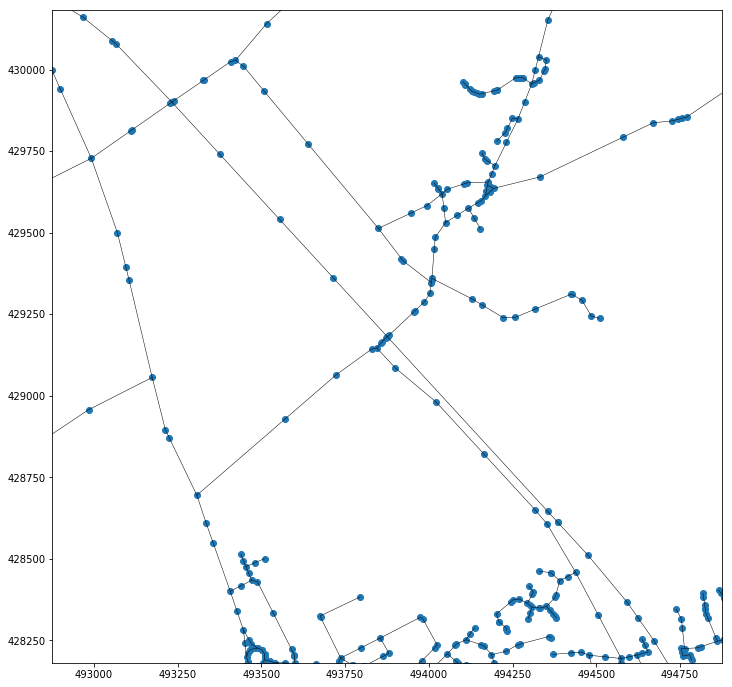

In [11]:
fig, ax = plt.subplots(figsize=(12,12))

lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
ax.add_collection(lc)

nodes = list(graph.vertices.values())
nodes = np.asarray(nodes)
ax.scatter(nodes[:,0], nodes[:,1])

xc, yc = 493875.67, 429181.32
si = 1000
ax.set(xlim=[xc - si, xc + si], ylim=[yc - si, yc + si])
None

Building r tree...


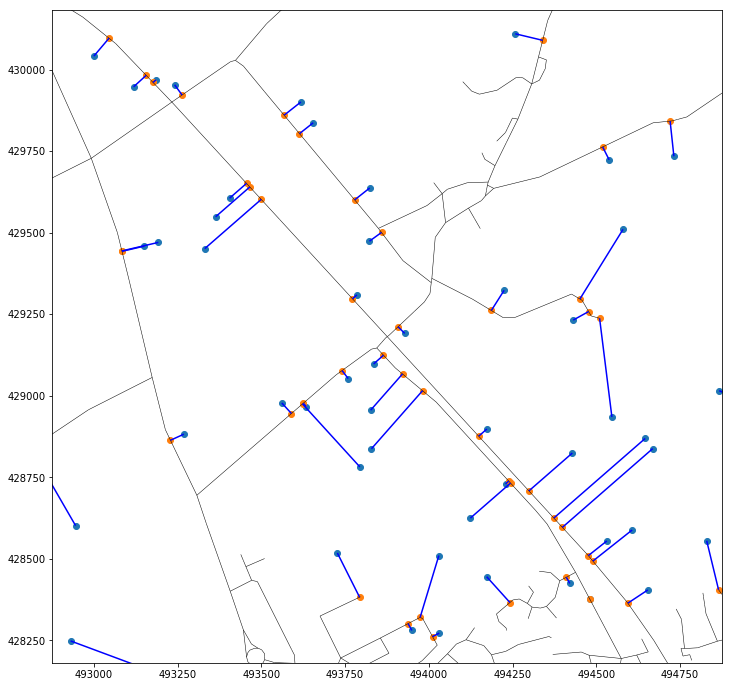

In [14]:
fig, ax = plt.subplots(figsize=(12,12))

lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
ax.add_collection(lc)

xc, yc = 493875.67, 429181.32
si = 1000
ax.set(xlim=[xc - si, xc + si], ylim=[yc - si, yc + si])

xcs = np.random.random(50) * si * 2 - si + xc
ycs = np.random.random(50) * si * 2 - si + yc
ax.scatter(xcs, ycs)
xxcs, yycs = [], []
for x, y in zip(xcs, ycs):
    edge, t = graph.project_point_to_graph(x, y)
    xx, yy = graph.edge_to_coords(*edge, t)
    xxcs.append(xx)
    yycs.append(yy)
ax.scatter(xxcs, yycs)

lines = [((x,y),(xx,yy)) for x,y,xx,yy in zip(xcs, ycs, xxcs, yycs)]
lc = matplotlib.collections.LineCollection(lines, color="blue")
ax.add_collection(lc)

# For US TIGER/Lines data

Here we have a lot less to go on: basically just geometry and a "name" for each edge.

What could go wrong if we form a graph in the same way:
- Perhaps edges which are meant to join up have slightly different x,y coords for the start/end points?  Answer: Yes!  But only by "_slightly_"
- In looking at this, we also find genuine points of intersection which are _not_ the start/end points of lines.
- So it's almost the exact opposite of the UK data...!

In [10]:
tiger_path = os.path.join("/media", "disk", "TIGER Data")
filename = os.path.join(tiger_path, "tl_2016_17031_roads")
tiger_frame = gpd.GeoDataFrame.from_file(filename)
chicago = tiger_frame.to_crs({"init":"epsg:3528"})
chicago.head()

,FULLNAME,LINEARID,MTFCC,RTTYP,geometry
0,47th Pl Exd,110380277026,S1400,M,LINESTRING (361283.8098974457 571774.357903373...
1,Golden Spr,110380298305,S1400,M,LINESTRING (334283.9373028304 555952.566653928...
2,Edens Expy Spr,1104259027148,S1100,M,LINESTRING (338674.4822622131 608835.390285893...
3,Edens Expy Spr,1104259564382,S1100,M,LINESTRING (341418.6466204406 608352.224489629...
4,Edens Expy Spr,1104472109755,S1100,M,LINESTRING (337922.7936322958 609174.983032155...


In [55]:
import pyproj
proj = pyproj.Proj({"init":"epsg:3528"})

In [11]:
start_end_nodes = []
for geo in chicago.geometry:
    lines = list(geo.coords)
    start_end_nodes.append(lines[0])
    start_end_nodes.append(lines[-1])
start_end_nodes = np.asarray(start_end_nodes)
start_end_nodes.shape

(158700, 2)

In [41]:
dists = []
odd_points = []
for i, pt in enumerate(start_end_nodes):
    diffs = start_end_nodes[i+1:, :] - pt[None,:]
    distsq = diffs[:,0]**2 + diffs[:,1]**2
    mask = (distsq < 1) & (distsq > 0)
    dists.extend(distsq[mask])
    if np.any(mask) > 0:
        for j, m in enumerate(mask):
            if m:
                odd_points.append((i,j+i+1))
    if len(dists) > 1000000:
        raise Bob

In [42]:
min(dists), max(dists)

(4.87890977618477e-19, 6.5899163296384566e-18)

In [43]:
odd_points[0]

(50, 110545)

In [45]:
# 50 == start point of 25
# 110545 == end point of 110544//2
chicago.ix[[25, 110544//2]]

,FULLNAME,LINEARID,MTFCC,RTTYP,geometry
25,Cedar Glen Dr N,110380338074,S1400,M,LINESTRING (364977.3143999526 540150.459265323...
55272,Cedar Glen Dr,1102154911164,S1640,M,LINESTRING (364948.2723670056 540150.086583519...


In [49]:
list(chicago.ix[25].geometry.coords)[0], list(chicago.ix[110544//2].geometry.coords)[-1]

((364977.3143999526, 540150.4592653238),
 (364977.3143999526, 540150.4592653245))

In [75]:
# Unprojected
list(tiger_frame.ix[25].geometry.coords)[0], list(tiger_frame.ix[110544//2].geometry.coords)[-1]

((-87.554755, 41.52960499999999), (-87.554755, 41.529605))

In [50]:
lines = open_cp.plot.lines_from_geometry(chicago.geometry)
type(lines), len(lines)

(list, 79350)

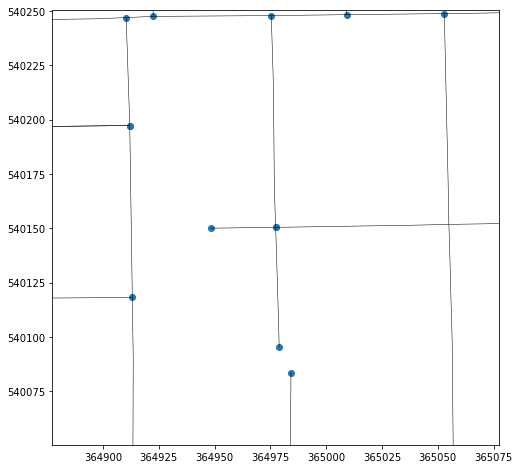

In [73]:
xc, yc = list(chicago.ix[25].geometry.coords)[0]

fig, ax = plt.subplots(figsize=(8,8))

lc = matplotlib.collections.LineCollection(lines, color="black", linewidth=0.5)
ax.add_collection(lc)

nodes = np.asarray(start_end_nodes)
ax.scatter(start_end_nodes[:,0], start_end_nodes[:,1])

si = 100
ax.set(xlim=[xc - si, xc + si], ylim=[yc - si, yc + si])
None

In [74]:
proj(xc, yc, inverse=True)

(-87.55475499999996, 41.52960499999997)